Introduction to EEG Analysis with PCA and ICA
=============================================

Welcome, colleague, to our tutorial on dimensional reduction with PCA and ICA! We hope you find it helpful in understanding what these techniques do, how and when to use them, and how to interpret the results of their application to EEG-like data.

Throughout this tutorial, we will use data that we produce from a simple model (described below) which we can use to generate data with prescribed features. We will then demonstrate how PCA and ICA can be used to, either separately or in conjunction, to extract these features from the data. In this way, we'll essentially perform a series of controlled experiments during which we'll put together a general framework for understanding the capabilities and limitations of PCA and ICA. Along the way, we will discuss how this framework can be used to guide the analysis of data in the 'real world' (i.e., for which the underlying structure is not known in advance).



A Note on our Intended Audience
-------------------------------

This tutorial is primarily designed for people studying neuroscience, though anybody interested in using or at least understanding PCA or ICA might find it useful. 

There are some mathematical discussions along the way, but these are intended to frame the essential features of PCA and ICA in such a way that we can better understand what the results of applying these techniques can and cannot tell us about our data.

We will assume little to no knowledge of Python or its most commonly used  numerical/scientific libraries (numpy, scipy, matplotlib, and scikit-learn), nor will we assume you have used jupyter notebooks before. The hope is that the code will be transparent enough for MATLAB users to catch on. For those of you that would like more background, we've provided a few places to start:

* Python: [A Beginner's tutorial](https://en.wikibooks.org/wiki/A_Beginner's_Python_Tutorial)
* Numpy/Scipy: [The official quickstart guide](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html)
* Matplotlib: [The official pyplot tutorial](http://matplotlib.org/users/pyplot_tutorial.html)
* scikit-learn: [The official documentation](http://scikit-learn.org/stable/documentation.html), which includes quick start guides and tutorials. 
* jupyter: [A good jupyter tutorial](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook), and a [handy cheat sheet](https://www.cheatography.com/weidadeyue/cheat-sheets/jupyter-notebook/)

Note, however, that there are plenty of tutorials out there aimed at people with various levels of familiarity with Python/programming. If these links aren't doing it for you, then it shouldn't be hard to find something that does.

Before we get started, let's get our modules imported and add a jupyter directive to make our plots display inline.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import IFrame

In [2]:
%matplotlib notebook

The Data Model
--------------

EEG (electroencephalography) is a technique for monitoring brain activity by recording voltage fluctuations through electrodes typically placed on the scalp. Most commonly, 19 recording electrodes are used, but high-density arrays can contain up to 256 electrodes placed more-or-less evenly around the scalp. For this tutorial, we have chosen to ignore the complex geometry of the head and instead use a simple two-dimensional model wherein 11 electrodes are placed evenly around the top half of the unit circle. 

To model voltage fluctuations picked up by the electrodes, we will pretend that we have three separete point-sources in the brain, each generating a distinct sinusoidal oscillation. These 'brain waves' radiate in all directions from their source, with exponentially decaying amplitudes, where they will be recorded by the electrodes. In keeping with the superposition principle, each electrode receives some mixture of the three source signals. By specifying the amplitudes and locations of the sources, we can control the relative strength of each source in a particular electrode.

In [3]:
IFrame("img/model_diagram.pdf", width=600, height=350)

This diagram represents the coronal view of our model, meaning we are looking at the subject 'face-on'. The skull/scalp is represented by the thick black semicircle, and the electrodes are evenly spaced over it, numbered 0–10 from the left, and the sources are represented by red disks. 

We use cartesian coordinates to specify locations of the sources and electrode, where the horizontal and vertical gray lines form the _x_- and _y_-axes, respectively. We have also chosen to simplify the geometry of the head, such that the skull forms the upper half of the unit circle, and the brain is defined as the upper half of the open unit disk.

To build our dataset, we need to specify the locations and properties of the sources. For example, we might represent the locations of the sources in the above diagram by the following:

In [4]:
# Specify the (x, y) coordinates of the sources.
s0_loc = np.array([-0.9, 0])
s1_loc = np.array([0, 0.9])
s2_loc = np.array([0.9, 0])

The location of the sources can be plotted natively:

<IPython.core.display.Javascript object>


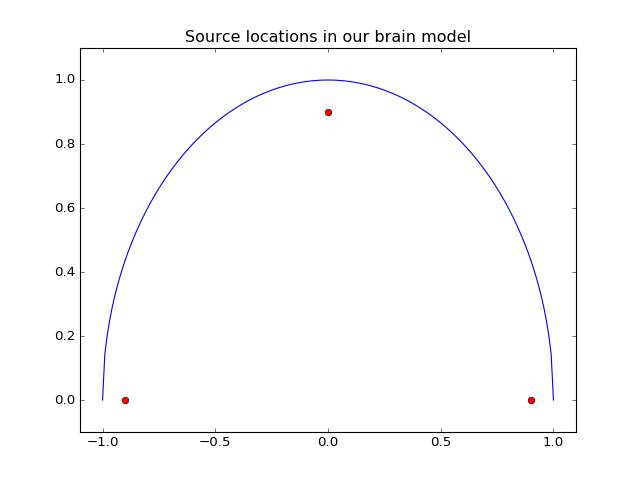

In [5]:
def plot_source_locs(a_loc,b_loc,c_loc):
    plt.figure()
    x = np.linspace(-1, 1, 200)
    y = np.sqrt(1-x**2)
    plt.plot(x,y)
    plt.plot([a_loc[0],b_loc[0],c_loc[0]],[a_loc[1],b_loc[1],c_loc[1]],'ro')
    plt.axis([-1.1, 1.1, -0.1, 1.1])
    plt.title('Source locations in our brain model')
    plt.show
    
plot_source_locs(s0_loc,s1_loc,s2_loc)

We can specify the sinusoidal properties of sources like so:

In [6]:
# Specify the frequencies, amplitudes, and phases (normalized) of three 
# sinusoids. Here, we're letting the phase of each sinusoid be chosen 
# uniformly at random.
amp_0, freq_0, phase_0 = 50.0, 10.0, np.random.random()   # Slow component.
amp_1, freq_1, phase_1 = 20.0, 15.0, np.random.random()   # Medium component.
amp_2, freq_2, phase_2 = 40.0, 25.0, np.random.random()   # Fast component.

# Create a time array representing a period of 2.5 seconds
# with a temporal resolution of 1000 Hz.
time = np.arange(0, 2.5, 1/1000) 

# Generate the sinusoids.
s0 = amp_0 * np.sin(2*np.pi*freq_0*(time + phase_0/freq_0))
s1 = amp_1 * np.sin(2*np.pi*freq_1*(time + phase_1/freq_1))
s2 = amp_2 * np.sin(2*np.pi*freq_2*(time + phase_2/freq_2))

The final step is to determine how much of each source is received by each electrode. As mentioned above, we'll let the amplitude of the source decay exponentially as we move away from its point of origin. In this way, we can design a 'mixing matrix' $M$, such that $M_{i, j} = \exp\left(-r_{ij}/\lambda\right)$, where $r_{ij}$ is the distance between source _i_ and electrode _j_, and $\lambda$ is the length constant over which a signal decays to $1/e$ of its starting value. The following function will create such a matrix:

In [7]:
from numpy.linalg import norm

def mixing_matrix(source_locs, decaylength=0.25, num_electrodes=11):
    
    """
    This function computes a 'mixing matrix' given the locations of 
    the sources, the decay rate of the sources, and the number of
    electrodes on the scalp.
    
    
    Parameters
    ----------
    
    source_locs : list-like
        An iterable of 2D coordinates that specify the locations
        of the sources.
    
    decaylength : float, optional
        Decay length of source signals.
        
    num_electrodes : int, optional
        Number of electrodes in EEG array.
        
    Returns
    -------
    
    M : numpy.ndarray
        Has the shape (num_electrodes, len(source_locs)).
                
    """
    
    # Generate locations of electrodes.
    electrode_locs = []
    for k in range(num_electrodes):
        x = -np.cos(np.pi * k/(num_electrodes-1))
        y =  np.sin(np.pi * k/(num_electrodes-1))
        electrode_locs.append(np.array([x, y]))
                
    # Convert elements of 'source_locs' to numpy arrays (if neccessary)
    # since we'll be doing arithmetic operations with them.
    source_locs = [np.array(loc) for loc in source_locs]

    # Create the mixing matrix.
    M = np.zeros((num_electrodes, len(source_locs)))
    for i, e_loc in enumerate(electrode_locs):
        for j, s_loc in enumerate(source_locs):
            M[i, j] = np.exp(-norm(e_loc - s_loc)/decaylength)
        
    return M

Finally, we can generate a mixing matrix and use it to 'project' the sources onto the electrodes.

In [8]:
# Create the mixing matrix.
M = mixing_matrix([s0_loc, s1_loc, s2_loc])

# Multiply 'M' by a matrix that the source signals.
eeg = np.dot(M, np.array([s0, s1, s2])).T

# Add some mild gaussian noise.
eeg += np.random.randn(*eeg.shape)

To visualize our data, let's define a function that will show display the time course of each electrode.

In [9]:
def show_eeg(time, eeg):

    """Plots the time course of each channel on separate axes.
    
    """
    # Find min and max vals so we can force all axes to have the same scaling.
    ylim = [np.floor(eeg.min()-1), np.ceil(eeg.max())+1]

    # Create the figure and plot each channel on its own axes.
    fig = plt.figure()
    for channel in range(eeg.shape[1]):

        ax = fig.add_subplot(eeg.shape[1], 1, channel+1)
        ax.plot(time, eeg[:, channel])
        ax.set_ylim(ylim)
        ax.set_ylabel('{}'.format(channel), rotation='horizontal')
        ax.yaxis.tick_right()

        # We only want ticks and labels on the bottom set of axes. Otherwise,
        # it gets too cluttered.
        if channel != eeg.shape[1]-1:
            ax.yaxis.set_ticklabels([''])
            ax.xaxis.set_ticklabels([''])            

        else:
            ax.set_xlabel('time (sec)')
            ax.yaxis.set_ticks(ylim)
    
    # Display and return the figure.
    plt.tight_layout()
    fig.show()
    return fig

<IPython.core.display.Javascript object>


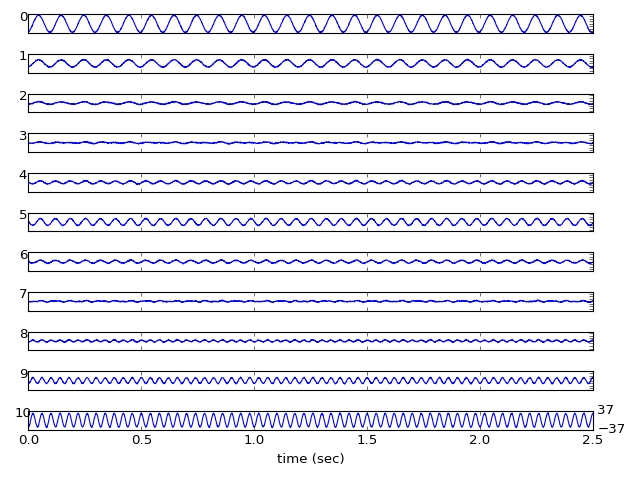

In [10]:
show_eeg(time, eeg);

(Note: The number on the left of each subplot indicates the electrode)

Does this make sense? Electrode 0 is in close proximity __s0__, our strong, slow-frequency source. Thus, electrode 0 looks like __s0__ much more than than the other sources. Electrode 1 also picks up __s0__, though its amplitude has diminished substantially. The same pattern holds for the other sources and electrodes.

Part 1: Principal Component Analysis (PCA)
------------------------------------------

Consider what we just did: we started with a small dataset (the 3 source signals) and transformed it into a much larger dataset (the 11 electrode signals). The goal of dimensional reduction is to run this process in reverse. 

But why? What would a lower dimensional description of a high-dimension system do for us that the data doesn't already? One possibility is that we as humans strongly prefer parsimonious explanations. There is a large aesthetic component to this preference. 





In principle, there are an infinite number of ways in which datasets of differing sizes can be related to each other. We have chosen a pretty tame relationship--an electrode's signal is simply the weighted sum of the source signals. As we'll see, even this simple transformation can present some difficulties, but we are now in a position to talk about PCA in context.

Imagine you were asked to reduce our dataset to some smaller number of dimensions. By eye, you would determine that electrode 1 is simply a scaled copy of electrode 0 and throw it out. Why? Your intuition is probably telling you that electrode 1 is redundant, and therefore contains no meaningful information.

PCA works a bit like this. In math-speak, electrodes 0 and 1 are highly covariant. So are electrodes 4, 5, and 6, and the same goes for electrodes 9 and 10. So now we have three groups, {0, 1}, {4, 5, 6}, and {9, 10}. Is it possible that group {0, 1} is covariant with group {9, 10}? After all, they're all sine waves, so there must be times when they're all moving in the same direction, right? Well... yes, but there are just as many times when they're moving in the opposite direction, so their covariance sums to zero. 

This relationship between sives waves of differing frequencies imbues them with a property that we call orthogonality. In a sense that can be made precise, our signals are easily separable into distinct groups. 

Back to PCA: The goal of PCA is to produce a set of axes that are best aligned with the variance in the data. A canonical example is shown below:

In [11]:
IFrame("img/scatter.png", width=700, height=700)

The observations are represented by points scattered in the plane, and the arrows represent the axes found by PCA. Why is one of the arrows longer? As you can see, the data varies much more in the direction of the long arrow. In this illustration, the length is just a reflection of this fact. How might this picture relate to our data?

Imagine (somehow) that we're in 11 dimensional space, and each axis represents the 'activity space' of one electrode. For the moment, imagine we are only looking at the activity of electrode 0. As time moves forward, the electrode's value moves back and forth along its axis, dropping a point at every time step. 

In [12]:
len(eeg[:,1])

2500

Now imagine that we are looking at a pair of electrodes, say electrode 0 and electrode 1, and plot the pairs $\left(\text{electrode}_0(t), \text{electrode}_1(t)\right)$ on the $\text{electrode}_{0,1}$ plane.

<IPython.core.display.Javascript object>


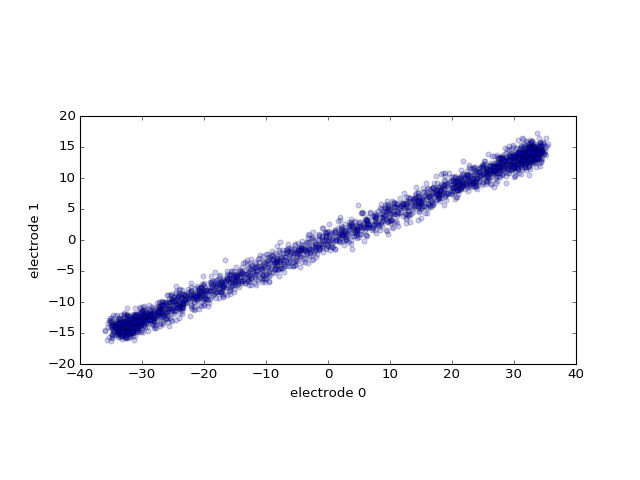

In [13]:
import matplotlib.cm as cm

def plot_electrode_data_2d(eeg,a,b,n_points=None,colored=False):

    fig, ax = plt.subplots()
    colors = cm.rainbow(np.linspace(0, 1, len(eeg[:n_points,a])))
    ax.scatter(eeg[:n_points, a], eeg[:n_points, b], alpha=0.2, color=colors if colored else None)
    ax.set_aspect('equal')
    ax.set_xlabel('electrode %d' % a)
    ax.set_ylabel('electrode %d' % b)
    fig.show();
    
plot_electrode_data_2d(eeg,0,1)
#plot_electrode_data_2d(eeg,0,1,colored=True) # to see this colored according to time

Since electrode 0 and electrode 1 are simply scaled copies of one another, their joint activity lies mostly along a line (but not exactly since we've added noise).

We can do something similar for electrodes {4, 5, 6} in the $\text{electrode}_{4,5,6}$ "plane":

<IPython.core.display.Javascript object>


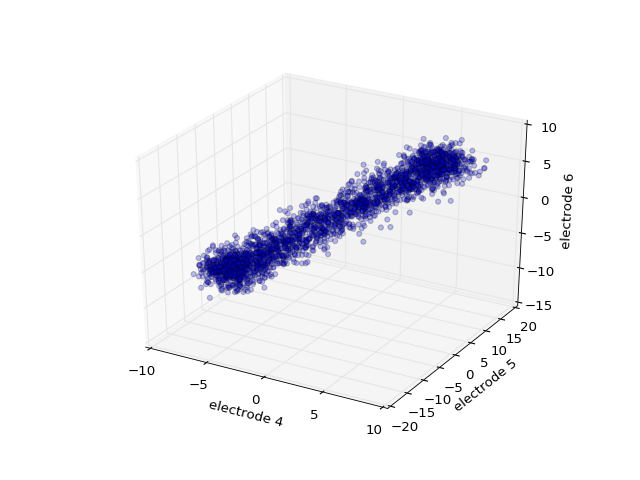

In [14]:
def plot_electrode_data_3d(eeg,a,b,c):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(eeg[:, a], eeg[:, b], eeg[:, c], alpha=0.25)
    ax.set_xlabel('electrode %d' % a)
    ax.set_ylabel('electrode %d' % b)
    ax.set_zlabel('electrode %d' % c)
    fig.show()
    
plot_electrode_data_3d(eeg,4,5,6)

As you can see, these points also lie along a line in the space spanned by electrodes {4, 5, 6}. The same pattern holds for electrodes {9, 10}:

<IPython.core.display.Javascript object>


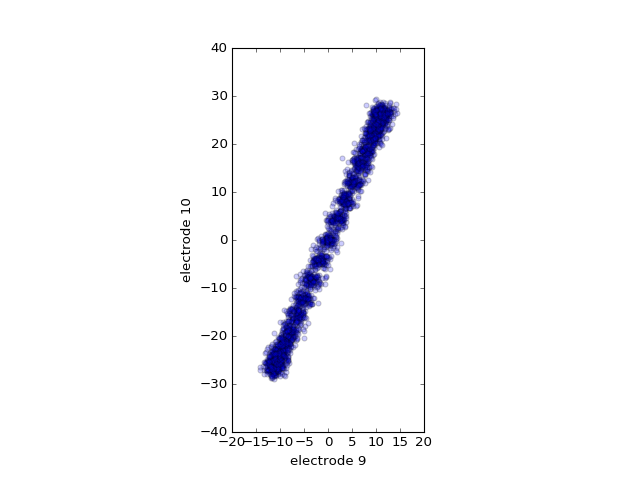

In [15]:
plot_electrode_data_2d(eeg,9,10)

Essentially, PCA finds these kinds of linear relationships and uses them to guide the construction of a new set of axes in in $n$-dimensional space (in our case, $n=11$). These axes are sometimes called principal components, but we'll call them principal axes. The important part is that each principal axis defines a direction along which the random variables move together.

Secondly, PCA puts these axes in a particular order. Since we'd like to know which trends are most prevalent in the data, PCA orders the axes by the amount of variance that they account for.

It's important critical to note that the axes produced by PCA will be orthogonal to one another. In practice, this means is that PCA won't be able to capture the underlying structure of a dataset that varies in more complicated ways.

Enough talk, let's do some PCA!

In [16]:
from sklearn.decomposition import PCA

# Create a PCA object and use it.
pca = PCA()
pca.fit(eeg)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In order to start making sense of the result, let's define a function that tells us about the variance explained by the principal axes (principal components).

In [17]:
def show_explained_variance(pca, threshold=0.98):
    
    # Initialize the figure.
    fig = plt.figure()

    # Get the explained variance ratios from the pca object.
    evr = pca.explained_variance_ratio_

    # First, make a bar plot the explained variance ratios.
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.bar(np.arange(len(evr))-0.4, evr, color='grey')
    ax1.set_ylim([0, 1])
    ax1.set_xlim([-0.4, len(evr)])
    ax1.set_xlabel('component')
    ax1.set_ylabel('fraction of variance explained')
    ax1.set_title('explained variance ratio')
    
    # Next, make a bar plot the cumulative explained variance ratios.
    ax2 = fig.add_subplot(2, 1, 2)
    cum_evr = np.cumsum(evr)
    ax2.bar(np.arange(1, len(cum_evr)+1)-0.4, cum_evr, color='grey')
    xlim = [0.4, len(evr)]
    ax2.xaxis.set_ticks(np.arange(1, len(cum_evr)+1))
    ax2.set_ylim([0, 1.1])
    ax2.set_xlim(xlim)
    ax2.set_xlabel('number of components')
    ax2.set_ylabel('fraction of variance explained')
    ax2.set_title('cumulative explained variance ratio')

    # Also plot the threshold line.
    X = np.array([xlim[0], xlim[1]])
    Y = np.ones_like(X) * threshold
    ax2.plot(X, Y, color='red')
    plt.tight_layout()
    fig.show()

<IPython.core.display.Javascript object>


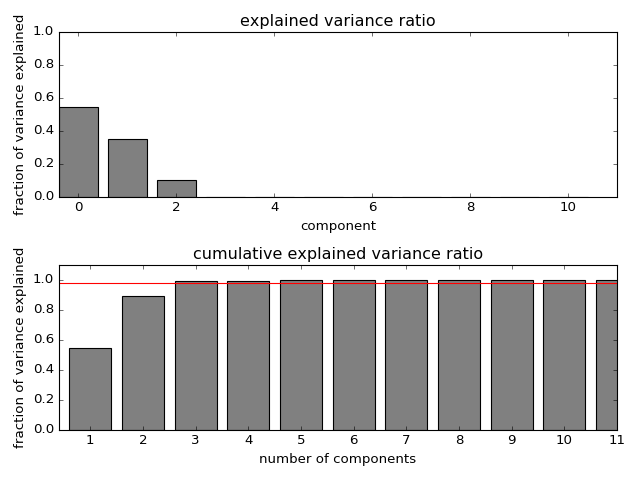

In [18]:
show_explained_variance(pca);

The upper plot shows the amount of variance explained by each principal axis/component. It looks like there are only three meaningful components in the data, and you'd be right to assume that they relate nicely to the sources __s0__, __s1__, and __s2__. 

The bottom plot shows the cumulative fraction of variance explained (e.g., the third bar shows the fraction of variance explained by the first three components). The red line represents the point at which 98% of the variance is explained. 

We can use this kind of analysis dimensionality reduction in a couple of ways. We could, for example, find the number of components required to explain a large percentage of the data. A related approach would be to throw away any components that don't meet some minimum threshold for variance explanation. 

In [19]:
def show_components(pca, num_components, time, eeg):
    
    """Display the principal axes and corresponding recovered signals.
    """

    transformed = pca.transform(eeg)
    
    # Initialize the figure and add a GridSpec for convenience.
    fig = plt.figure()
    gs = gridspec.GridSpec(num_components, num_components)
    
    # Find min and max vals so we can get all principal axes subplots to 
    # be scaled the same way.
    transformed = transformed[:, 0:num_components]
    ylim = [np.floor(transformed.min()), np.ceil(transformed.max())]
    
    # Plot each principal axis next to its recovered signal.
    for i in range(num_components):
        
        ax1 = fig.add_subplot(gs[i, 0])
        ax2 = fig.add_subplot(gs[i, 1])

        # If we're at the top, add titles.
        if i == 0:
            ax1.set_title('principal axes\n(principal components)')
            ax2.set_title('recovered signals')
            ax2.set_xlabel('time (sec)')
        
        # Show principal axis.
        axis_Y = pca.components_[i]
        axis_X = np.arange(len(axis_Y)) - 0.4
        ax1.bar(axis_X, axis_Y, color='grey')
        ax1.set_ylim([-1.1, 1.1])
        ax1.set_xlim([-0.4, len(axis_X)])

        # Show recovered signals.
        ax2.plot(time, transformed[:, i])
        ax2.set_ylim(ylim)
        ax2.set_xlim([0,0.5])

    plt.tight_layout()
    fig.show()

<IPython.core.display.Javascript object>


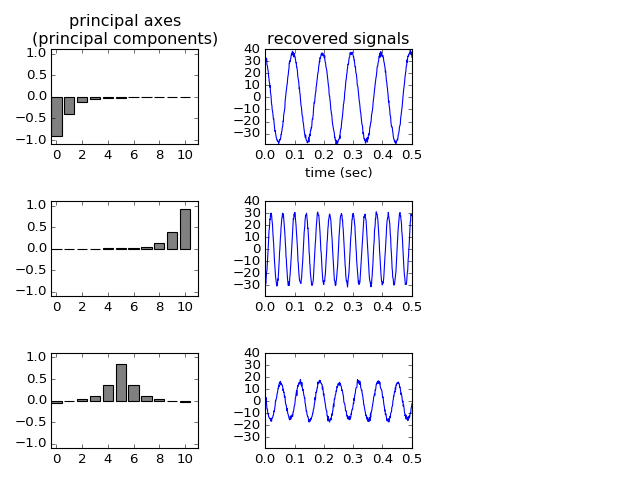

In [20]:
show_components(pca, 3, time, eeg);

These plots are arranged so that the top pair corresponds to the principal axis that explains the most variance, the second pair corresponds to the principal axis that explains the second most variance, and so on.

The plots on the left show that the principal axes are oriented mostly along the 0th, 10th and 5th electrodes respectively, corresponding to the respective electrodes which the three signals maximally influence.

Sources originating more deeply
---

Now let's try something a little more complicated. In particular, let's explore what happens when the sources are located more deeply in the brain. 

<IPython.core.display.Javascript object>


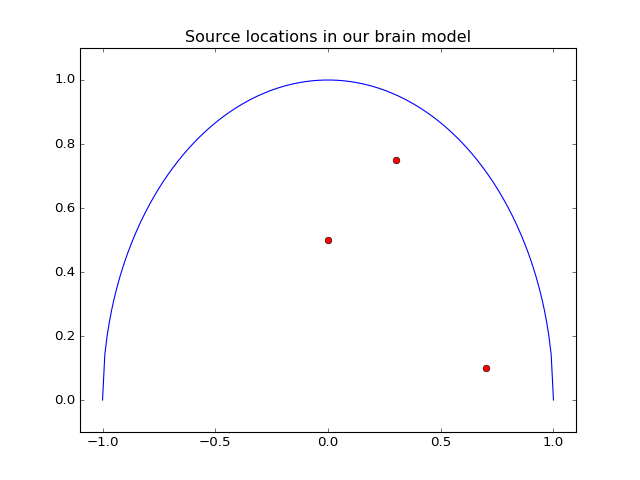

In [21]:
# Specify the new (x, y) coordinates of our sources.
s0_loc_deep = np.array([0, 0.5])
s1_loc_deep = np.array([.7, 0.1])
s2_loc_deep = np.array([.3, 0.75])

plot_source_locs(s0_loc_deep,s1_loc_deep,s2_loc_deep)

Let's have a look at the EEG data.

In [22]:
# Generate a new mixing matrix, and use it to create electrode data
# with some mild gaussian noise.
M = mixing_matrix([s0_loc_deep, s1_loc_deep, s2_loc_deep])
eeg_deep = np.dot(M, np.array([s0, s1, s2])).T
eeg_deep += 0.5*np.random.randn(*eeg_deep.shape)

<IPython.core.display.Javascript object>


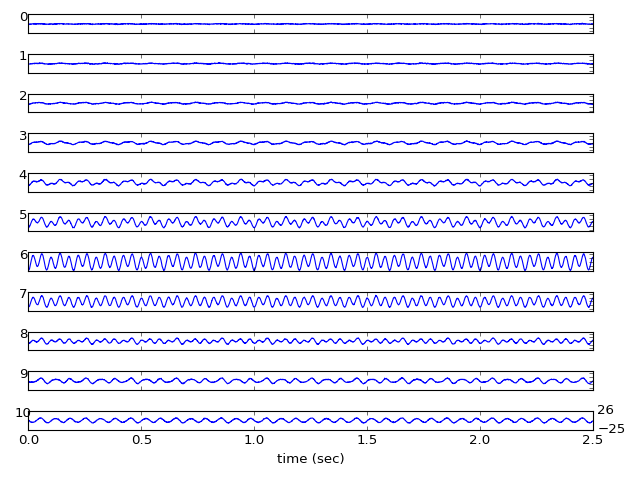

In [23]:
show_eeg(time, eeg_deep);

Repeating the analysis we did above, 

In [24]:
# Fit the new data.
pca = PCA()
pca.fit(eeg_deep)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>


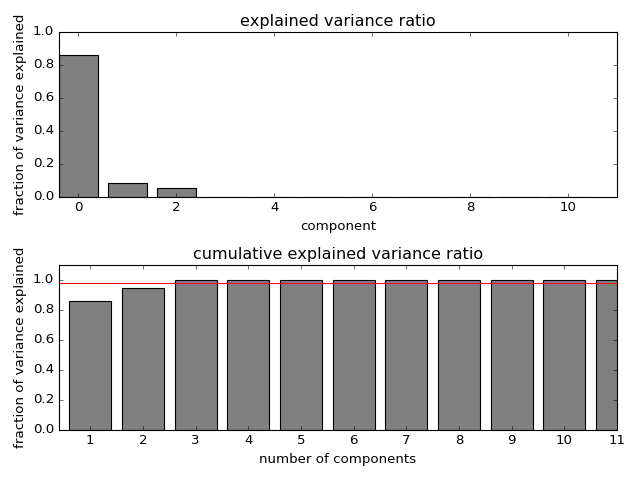

In [25]:
# What principal components do we find now?
show_explained_variance(pca);

It looks like having signals bleed into nearby channels didn't affect much in the way of explained variance. How about the principal axes themselves?

<IPython.core.display.Javascript object>


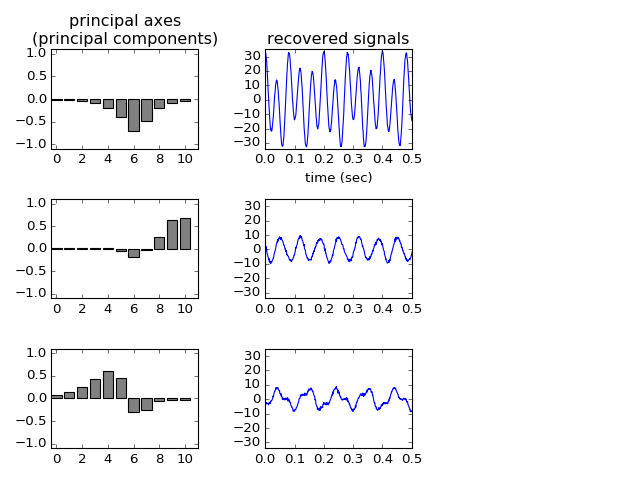

In [26]:
show_components(pca, 3, time, eeg_deep);

What's going on here? While the second recovered signal matches one of our sources, the other two recovered signals do not. To get a handle on this phenomenon, let us plot the EEG data on the Electrode 4–Electrode 6 plane. These two electrodes are the ones along which the first and third principal axes are most oriented.

<IPython.core.display.Javascript object>


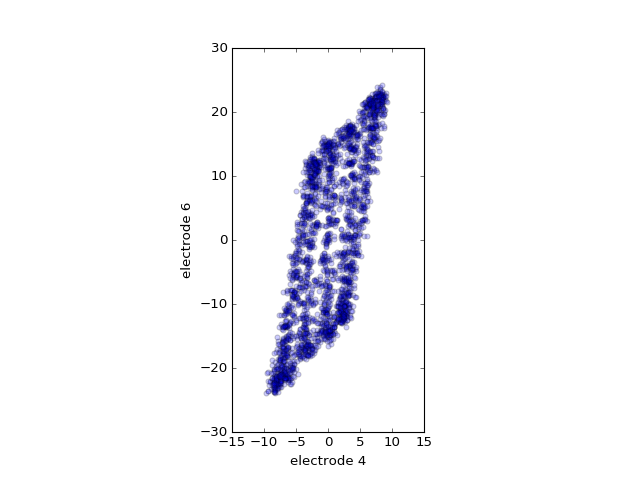

In [27]:
plot_electrode_data_2d(eeg_deep,4,6)

We can observe correlations in the data, as projected onto this plane. However, the correlations are nonlinear, unlike the ones seen in the shallow-source EEG earlier. By eye, we can distinguish two independent axes along which the data varies, corresponding to the effects of the sinusoidal sources **s0** and **s2**:

<IPython.core.display.Javascript object>


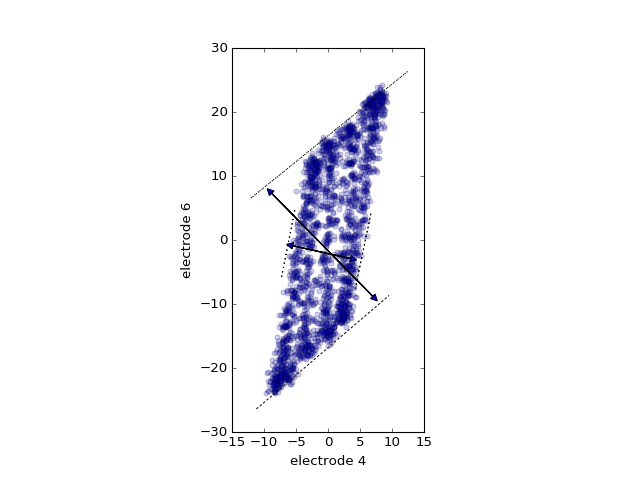

In [28]:
fig, ax = plt.subplots()
ax.scatter(eeg_deep[:, 4], eeg_deep[:, 6], alpha=0.2)

#Obtain limits based on the scatter plot, so that we can freeze the limits later
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# Draw arrows and dotted lines to demonstrate the 
# independent axes derived by eye
ax.arrow(7,-8.8,-8.8-7,7.3+8.8,head_width=1,head_length=1)
ax.arrow(-8.8,7.3,7+8.8,-8.8-7.3,head_width=1,head_length=1)
ax.arrow(-12.1,6.5,12.4+12.1,26.3-6.5,linestyle=':')
ax.arrow(-11.3,-26.5,9.5+11.3,-8.7+26.5,linestyle=':')
ax.arrow(-5.5,-.9,3.5+5.5,-2.9+.9,head_width=1,head_length=1)
ax.arrow(3.5,-2.9,-(3.5+5.5),-(-2.9+.9),head_width=1,head_length=1)
ax.arrow(-7.3,-6,-5.2+7.3,4.6+6.0,linestyle=':')
ax.arrow(4.2,-7.9,6.7-4.2,4.1+7.9,linestyle=':')

ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax)
ax.set_aspect('equal')
ax.set_xlabel('electrode 4')
ax.set_ylabel('electrode 6')
fig.show();

However, PCA considers correlations as though they were linear, and designates an axis so as to maximize the variance along it. The remaining principal axes are drawn with the constraint that they are orthogonal to the existing principal axes.

<IPython.core.display.Javascript object>


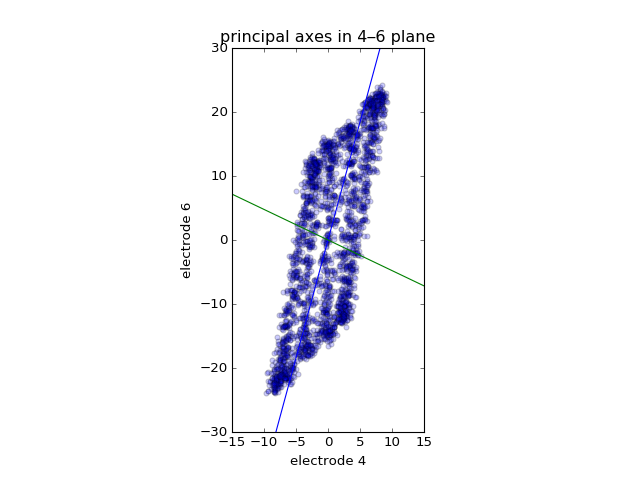

In [29]:
fig, ax = plt.subplots()
ax.scatter(eeg_deep[:, 4], eeg_deep[:, 6], alpha=0.2)
# Obtain the limits based on the scatter above
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

comps = np.array([0,1,2])
# Delete the axis associated with s1, nearest to Electrode 10
comps = np.delete(comps,np.argmax(pca.components_[0:2,10]))
grad0 = pca.components_[comps[0],6]/pca.components_[comps[0],4]
grad1 = pca.components_[comps[1],6]/pca.components_[comps[1],4]
ax.plot([xmin,xmax],[grad0*xmin,grad0*xmax],'-')
ax.plot([xmin,xmax],[grad1*xmin,grad1*xmax],'-')
ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax)
ax.set_aspect('equal')
ax.set_xlabel('electrode 4')
ax.set_ylabel('electrode 6')
ax.set_title('principal axes in 4–6 plane')
fig.show();

PCA fails to recover our original sources completely because our data contains axes correlated with each other in a nonlinear fashion, due to a high degree of (linear) mixing of the sources.

Part 2: Independent component analysis (ICA)
======

ICA is a robust method of recovering signals that have been linearly mixed with each other. The independent axes (independent components) are not constrained to be orthogonal, and the method deals with nonlinear correlations between independent axes, dealing with the difficulties that we have highlighted at the end of the previous section.

PCA and ICA are analogous in the sense that while PCA orients axes to maximize variance, ICA orients axes to maximize non-Gaussianity (kurtosis). This allows ICA to maximize the independence of the sources, thus recovering the original sources that were mixed to produce the observed data. [Delorme's EEG lab website](https://sccn.ucsd.edu/~arno/indexica.html) features an introduction to the mathematical details, which are too involved to be discussed here. In the following section, we will demonstrate its power.

Recall that we previously performed PCA on the full EEG:

~~~~
pca = PCA()
pca.fit(eeg_deep)
show_components(pca, 3, time, eeg_deep);
~~~~

The array `transformed` stores the principal components, ordered in decreasing order of explained variance. We are thus able to apply ICA to the first few principal components we obtained above in order to uncover the underlying signals:

<IPython.core.display.Javascript object>


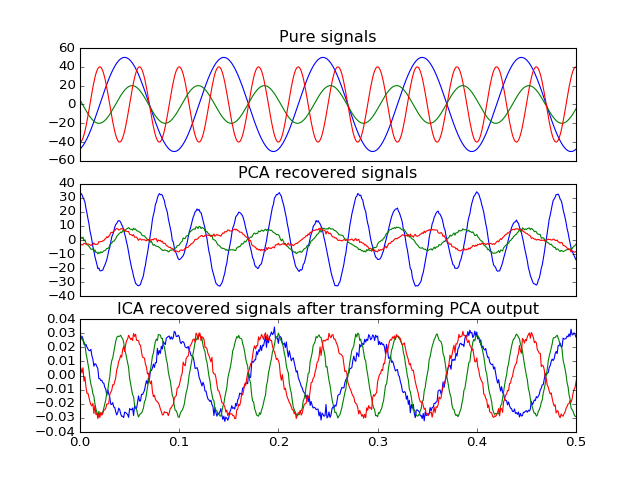

In [30]:
from sklearn.decomposition import PCA, FastICA

pca = PCA()
pca.fit(eeg_deep)
pca_transformed = pca.transform(eeg_deep)

ica = FastICA()
ica_pca_transformed = ica.fit_transform(pca_transformed[:,0:3])

plt.figure()
plt.subplot(311).plot(time,np.array([s0,s1,s2]).T)
plt.subplot(311).set_title('Pure signals')
plt.subplot(311).get_xaxis().set_visible(False)
plt.subplot(311).set_xlim([0,0.5])
plt.subplot(312).plot(time,pca_transformed[:,0:3])
plt.subplot(312).set_title('PCA recovered signals')
plt.subplot(312).get_xaxis().set_visible(False)
plt.subplot(312).set_xlim([0,0.5])
plt.subplot(313).plot(time,ica_pca_transformed)
plt.subplot(313).set_title('ICA recovered signals after transforming PCA output')
plt.subplot(313).set_xlim([0,0.5])
plt.show()

# We could have instead used 

# perform_ica(transformed[:,0:3])

# but this would not plot the middle graph

Up to sign inversions, ICA recovers the signals pretty decently. Note the following limitations:
- ICA does not recover the magnitudes of the original signals, due its mathematical implementation.
- Unlike PCA, which ranks the signals by explained variance, ICA does not rank the signals.

We can also perform matrix multiplication of the ICA and PCA results to obtain the principal axes.

<IPython.core.display.Javascript object>


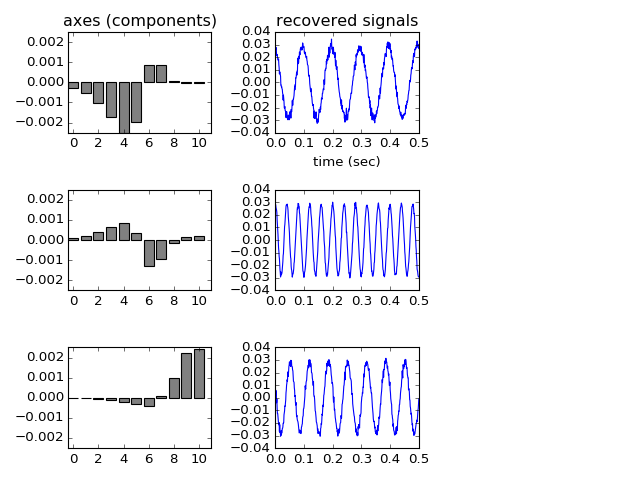

In [31]:
def show_components_hybrid(pca, ica, num_components, time, transformed):
    
    # Get the unmixing matrix
    unmixing=np.dot(ica.components_,pca.components_[0:3,:])
    ylim_unmixing = np.maximum(np.absolute(unmixing.min()),np.absolute(unmixing.max()))
    
    # Initialize the figure and add a GridSpec for convenience.
    fig = plt.figure()
    gs = gridspec.GridSpec(num_components, num_components)
    
    # Find min and max vals so we can get all signal subplots to 
    # be scaled the same way.
    transformed = transformed[:, 0:num_components]
    ylim = [np.floor(transformed.min()), np.ceil(transformed.max())]
    
    # Plot each axis next to its recovered signal.
    for i in range(num_components):
        
        ax1 = fig.add_subplot(gs[i, 0])
        ax2 = fig.add_subplot(gs[i, 1])

        # If we're at the top, add titles.
        if i == 0:
            ax1.set_title('axes (components)')
            ax2.set_title('recovered signals')
            ax2.set_xlabel('time (sec)')
        
        # Show axis.
        axis_Y = unmixing[i]
        axis_X = np.arange(len(axis_Y)) - 0.4
        ax1.bar(axis_X, axis_Y, color='grey')
        ax1.set_ylim([-ylim_unmixing, ylim_unmixing])
        ax1.set_xlim([-0.4, len(axis_X)])

        # Show components.
        ax2.plot(time, transformed[:, i])
       # ax2.set_ylim(ylim)
        ax2.set_xlim([0,0.5])

    plt.tight_layout()
    fig.show()
    
show_components_hybrid(pca, ica, 3, time, ica_pca_transformed);

We can plot the axes in the Electrode 4–Electrode 6 plane, as we have done above.

<IPython.core.display.Javascript object>


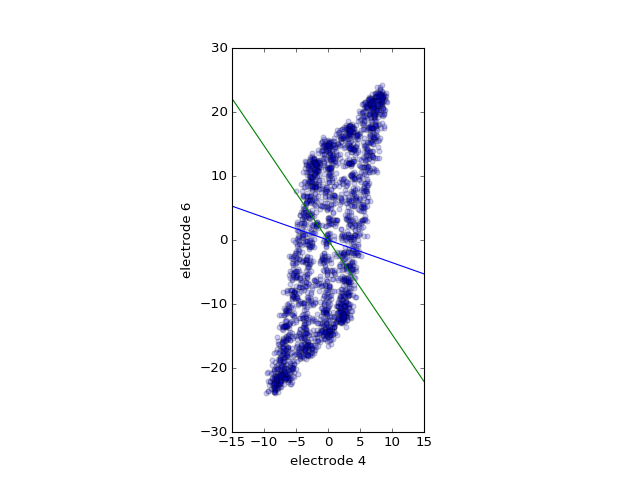

In [32]:
fig, ax = plt.subplots()
ax.scatter(eeg_deep[:, 4], eeg_deep[:, 6], alpha=0.2)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
unmixing=np.dot(ica.components_,pca.components_[0:3,:])

comps = np.array([0,1,2])
# Delete the axis associated with s1, nearest to Electrode 10
comps = np.delete(comps,np.argmax(unmixing[:,10]))

grad0 = unmixing[comps[0],6]/unmixing[comps[0],4]
grad1 = unmixing[comps[1],6]/unmixing[comps[1],4]
ax.plot([xmin,xmax],[grad0*xmin,grad0*xmax],'-')
ax.plot([xmin,xmax],[grad1*xmin,grad1*xmax],'-')
ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax)
ax.set_aspect('equal')
ax.set_xlabel('electrode 4')
ax.set_ylabel('electrode 6')
fig.show();

This is similar to what we identified by eye. Impressive!

Performing ICA directly on the dataset <br />when the number of components is known
-----------

Let's look at what happens if we attempt to perform ICA from the start, without first performing PCA.

In [33]:
from sklearn.decomposition import FastICA

def perform_ica(eeg,max_iter=200,n_components=None):
    ica = FastICA(max_iter=max_iter,n_components=n_components)
    ica_transformed = ica.fit_transform(eeg)
    plt.figure()
    plt.subplot(211).plot(time,np.array([s0,s1,s2]).T)
    plt.subplot(211).set_title('Original signals')
    plt.subplot(211).set_xlim([0,0.5])
    plt.subplot(212).plot(time,ica_transformed)
    plt.subplot(212).set_title('ICA recovered signals')
    plt.subplot(212).set_xlim([0,0.5])
    plt.show()
    
    return ica_transformed

//anaconda/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


<IPython.core.display.Javascript object>


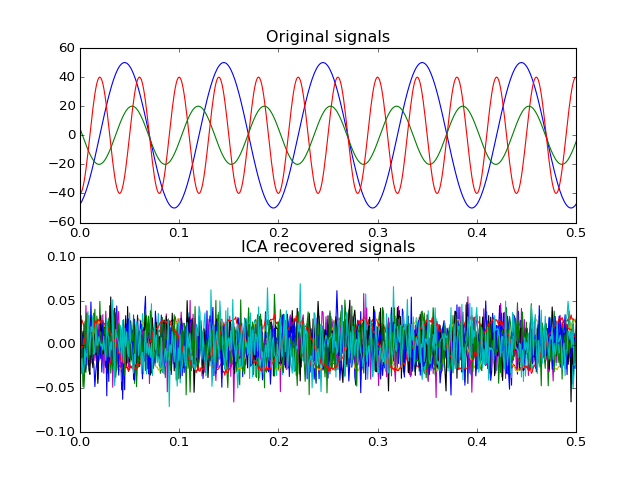

In [34]:
perform_ica(eeg_deep);

ICA attempts to extract 10 sources from the data, so most of the recovered sources are actually just noise, and also fails to converge.

However, this can be fixed by specifying that there are only 3 sources from the data:

<IPython.core.display.Javascript object>


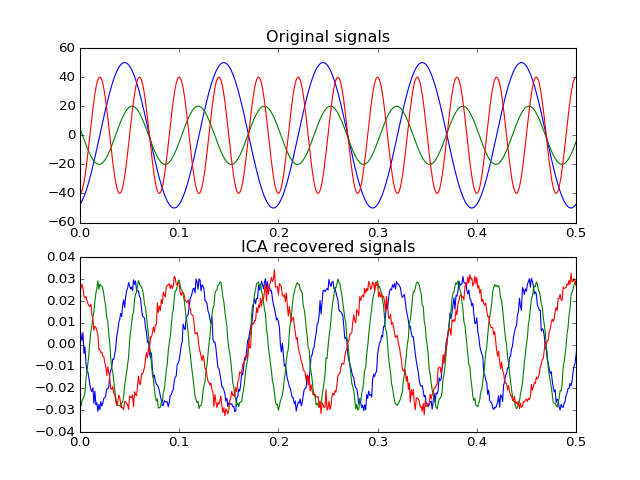

In [35]:
ica_direct_transformed = perform_ica(eeg_deep,200,3);

Let's look at the axes alongside the components.

<IPython.core.display.Javascript object>


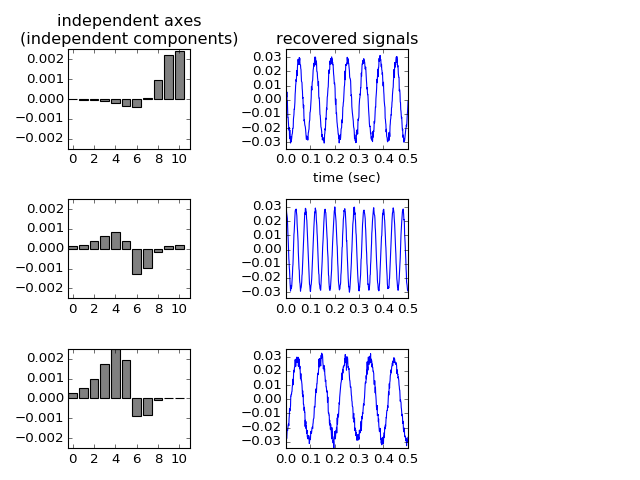

In [36]:
def show_ica_components(ica, num_components, time, eeg):
    
    """Display the principal axes and recovered signals.
    """
    
    transformed = ica.fit_transform(eeg)
    
    ylim_unmixing = np.maximum(np.absolute(ica.components_.min()),np.absolute(ica.components_.max()))
    
    # Initialize the figure and add a GridSpec for convenience.
    fig = plt.figure()
    gs = gridspec.GridSpec(num_components, num_components)
    
    # Find min and max vals so we can get all recovered signal subplots to 
    # be scaled the same way.
    transformed = transformed[:, 0:num_components]
    ylim = [transformed.min(), transformed.max()]
    
    # Plot each principal axis next to its recovered signal.
    for i in range(num_components):
        
        ax1 = fig.add_subplot(gs[i, 0])
        ax2 = fig.add_subplot(gs[i, 1])

        # If we're at the top, add titles.
        if i == 0:
            ax1.set_title('independent axes\n(independent components)')
            ax2.set_title('recovered signals')
            ax2.set_xlabel('time (sec)')
        
        # Show principal axis.
        axis_Y = ica.components_[i]
        axis_X = np.arange(len(axis_Y)) - 0.4
        ax1.bar(axis_X, axis_Y, color='grey')
        ax1.set_ylim([-ylim_unmixing, ylim_unmixing])
        ax1.set_xlim([-0.4, len(axis_X)])

        # Show recovered signals.
        ax2.plot(time, transformed[:, i])
        ax2.set_ylim(ylim)
        ax2.set_xlim([0,0.5])

    plt.tight_layout()
    fig.show()
    
ica = FastICA(n_components = 3)
show_ica_components(ica,3,time,eeg_deep)

Let's compare the results of performing ICA on the PCA output, and performing ICA directly on the EEG data.

//anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


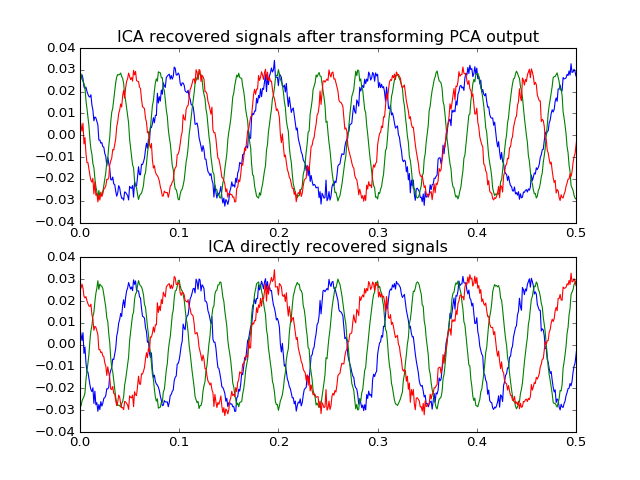

In [37]:
plt.figure()
plt.subplot(211).plot(time,ica_pca_transformed)
plt.subplot(211).set_title('ICA recovered signals after transforming PCA output')
plt.subplot(211).set_xlim([0,0.5])
plt.subplot(212).plot(time,ica_direct_transformed)
plt.subplot(212).set_title('ICA directly recovered signals')
plt.subplot(212).set_xlim([0,0.5])
plt.show()

As far as one can tell, the results are identical. In fact, the difference between the recovered sources are on the order of 0.1%.

On the other hand, because ICA does not rank the independent sources, when the number of sources is unknown, it can be cumbersome to guess the number of sources and check the ICA results. PCA offers a principled way of deciphering the number of sources, through the explained variance of each component. Thus, performing PCA, then ICA, is a good general strategy.